In [68]:
import os
import sys
working_dir = os.path.join(os.getcwd().split("Text2BGAudio")[0],'Text2BGAudio')
sys.path.append(working_dir)
os.chdir(working_dir)
from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter,defaultdict
from tqdm import tqdm
from Dataset_Creation import audio_dataset
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")

CLAP_ARCH = "laion/larger_clap_music"


Device Name: NVIDIA GeForce RTX 4080 SUPER


In [46]:
class EmbeddedDataset(Dataset):
    def __init__(self, embedded_data):
        self.embedded_data = embedded_data
    def __len__(self):
        return len(self.embedded_data)
    def __getitem__(self, idx):
        x,y= self.embedded_data[idx]
        return x,y

criterion = torch.nn.CrossEntropyLoss()
class MLPHead(torch.nn.Module):
    def __init__(self, input_dim=512, output_dim=6, hidden_dim=256):
        super(MLPHead, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.mlp(x)

In [ ]:
label_to_index  = {'Angry' : 0, 'Joy' : 1, 'Love' : 2, 'Sad' : 3, 'Scary' : 4, 'Surprise' : 5}
index_to_label = {v: k for k, v in label_to_index.items()}

def create_embedded_ds(ds_path,model_path = None,return_indexed=True):
    model_name = os.path.basename(model_path).split('.')[0] if model_path is not None else 'classic'
    model_output_folder = os.path.join(os.path.dirname(ds_path),'embedded_datasets',model_name)
    os.makedirs(model_output_folder,exist_ok=True)
    embedded_ds_path = os.path.join(model_output_folder,os.path.basename(ds_path).split('.')[0] + "_embedded.pt")
    if os.path.isfile(embedded_ds_path):
        print(f"Loading Embedded Dataset {os.path.basename(embedded_ds_path)} w/ {model_name} clap_model")
        embedded_data = torch.load(embedded_ds_path,weights_only=False)
    else:
        print(f"Creating Embedded Dataset {os.path.basename(embedded_ds_path)} w/ {model_name} clap_model")
        dataset = audio_dataset.AudioDataset(ds_path)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

        clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
        processor = ClapProcessor.from_pretrained(CLAP_ARCH)
        if model_path is not None:
            clap_model.load_state_dict(torch.load(model_path,weights_only=False)['model_state_dict'])

        embedded_data =list()
        with torch.no_grad():
            for batch in tqdm(data_loader,desc="Batches"):
                audio = batch[0]
                labels = list(batch[1])
                unique_labels = list(set(labels))
                inputs = processor(
                    text=unique_labels,
                    audios=audio.numpy(),
                    return_tensors="pt",
                    sampling_rate=48000,
                    padding=True,
                )
                inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                outputs = clap_model(**inputs)
                audio_embeds = outputs.audio_embeds
                embedded_data.extend([(audio_embed.cpu().detach(), label) for audio_embed, label in zip(audio_embeds, labels)])
        torch.save(embedded_data,embedded_ds_path)
    if return_indexed:
        embedded_data_indexed = [(audio_embed.cpu().detach(), label_to_index[label]) for audio_embed, label in embedded_data]
        return EmbeddedDataset(embedded_data_indexed)

In [64]:
model_path = r"CLAP\models\clap_fine_tunned_BatchSize_32_LR_1e-05_Epochs_50_LOSS_27.06.pt"
train_dataset_path = r"_Data\Music\music_dataset_train_size7507.pt"
val_dataset_path = r"_Data\Music\music_dataset_test_size39.pt"
train_dataset = create_embedded_ds(train_dataset_path,model_path)
val_dataset = create_embedded_ds(val_dataset_path,model_path)

Creating Embedded Dataset music_dataset_train_size7507_embedded.pt


Batches: 100%|██████████| 235/235 [02:12<00:00,  1.78it/s]


Creating Embedded Dataset music_dataset_test_size39_embedded.pt


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Epoch 1/100, Loss: 1.3198498487472534, Train Acc : 0.7016118289596377 , Val Acc : 0.41025641025641024
Epoch 2/100, Loss: 1.2796038389205933, Train Acc : 0.7675502863993606 , Val Acc : 0.48717948717948717
Epoch 3/100, Loss: 1.2783114910125732, Train Acc : 0.8067137338484082 , Val Acc : 0.6666666666666666
Epoch 4/100, Loss: 1.2508524656295776, Train Acc : 0.8161715731983482 , Val Acc : 0.6666666666666666
Epoch 5/100, Loss: 1.2115737199783325, Train Acc : 0.8200346343412814 , Val Acc : 0.6666666666666666
Epoch 6/100, Loss: 1.1572918891906738, Train Acc : 0.8233648594644998 , Val Acc : 0.6666666666666666
Epoch 7/100, Loss: 1.2704182863235474, Train Acc : 0.8254962035433595 , Val Acc : 0.6666666666666666
Epoch 8/100, Loss: 1.1960431337356567, Train Acc : 0.8234980684694285 , Val Acc : 0.6666666666666666
Epoch 9/100, Loss: 1.1591846942901611, Train Acc : 0.8280271746370055 , Val Acc : 0.6666666666666666
Epoch 10/100, Loss: 1.2510610818862915, Train Acc : 0.8285600106567204 , Val Acc : 0.6666

Text(0, 0.5, 'Accuracy')

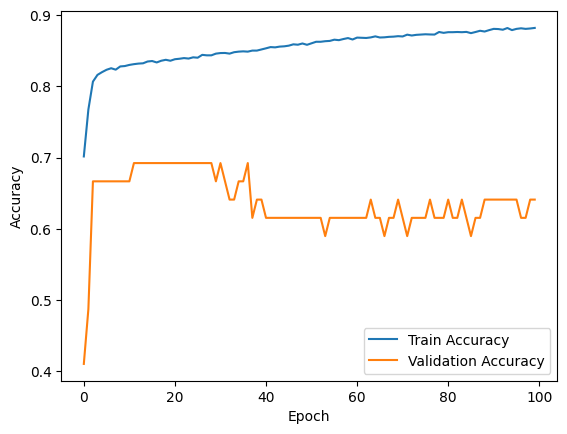

In [65]:
batch_size = 128
epochs = 100
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

classification_head = MLPHead().to(DEVICE)
optimizer = torch.optim.Adam(classification_head.parameters(), lr=5e-4)

train_acc = list()
val_acc = list()
for e in range(epochs):
    train_correct = 0
    for batch in train_data_loader:
        audio_embeds, labels = batch
        audio_embeds = audio_embeds.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == labels).item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_acc.append(train_correct/len(train_dataset))
    with torch.no_grad():
        val_correct = 0
        for batch in val_data_loader:
            audio_embeds, labels = batch
            # audio_embeds = F.normalize(audio_embeds, p=2, dim=1)
            audio_embeds = audio_embeds.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = classification_head(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == labels).item()
        val_acc.append(val_correct/len(val_dataset))
    print(f"Epoch {e+1}/{epochs}, Loss: {loss.item()}, Train Acc : {train_acc[-1]} , Val Acc : {val_acc[-1]}")

plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


### Train CLAP and MLP together

In [75]:
train_dataset_path = r"_Data\Music\music_dataset_train_size7507.pt"
val_dataset_path = r"_Data\Music\music_dataset_test_size39.pt"
train_dataset  = audio_dataset.AudioDataset(train_dataset_path)
val_dataset = audio_dataset.AudioDataset(val_dataset_path)

In [80]:
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [ ]:

# Load the model and processor
clap_model_path = r"CLAP\models\clap_fine_tunned_BatchSize_32_LR_1e-05_Epochs_50_LOSS_27.06.pt"
processor = ClapProcessor.from_pretrained(CLAP_ARCH)
clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
clap_model.load_state_dict(torch.load(clap_model_path, weights_only=False)['model_state_dict'])

# Initialize the MLP head
MLP_HEAD = MLPHead().to(DEVICE)
for param in clap_model.parameters():
    param.requires_grad = False
# Unfreeze audio projection heads
for param in clap_model.audio_projection.parameters():
    param.requires_grad = True

# Hyperparameters
epochs = 50
batch_size = 128
lr = 1e-5

# Data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(
    [
        {'params': clap_model.parameters(), 'lr': 1e-5},
        {'params': MLP_HEAD.parameters(), 'lr': 1e-3}
    ]
)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Accuracy lists
acc_list = {"train": [], "val": []}

# Training loop
for e in range(epochs):
    clap_model.train()
    MLP_HEAD.train()
    train_correct = 0
    total_loss = 0
    for batch in tqdm(train_data_loader, desc="Batches"):
        audio = batch[0]
        train_labels = list(batch[1])
        unique_labels = train_labels[:1]  # Not needed for inference
        inputs = processor(
            text=unique_labels,
            audios=audio.numpy(),
            return_tensors="pt",
            sampling_rate=48000,
            padding=True,
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = clap_model(**inputs)
        audio_embeds = outputs.audio_embeds
        outputs = MLP_HEAD(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in train_labels]).to(DEVICE)).item()
        loss = criterion(outputs, torch.tensor([label_to_index[label] for label in train_labels]).to(DEVICE))
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = train_correct / len(train_dataset)
    acc_list['train'].append(train_acc)
    
    clap_model.eval()
    MLP_HEAD.eval()
    val_correct = 0
    with torch.no_grad():
        for batch in val_data_loader:
            audio = batch[0]
            val_labels = list(batch[1])
            unique_labels = val_labels[:1]
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            outputs = MLP_HEAD(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in val_labels]).to(DEVICE)).item()
    val_acc = val_correct / len(val_dataset)
    acc_list['val'].append(val_acc)
    
    print(f"Epoch {e+1}/{epochs}, Loss: {total_loss / len(train_data_loader)}, Train Acc: {train_acc}, Val Acc: {val_acc}")

# Print final accuracies
print("Final Training Accuracy:", acc_list['train'][-1])
print("Final Validation Accuracy:", acc_list['val'][-1])

Batches: 100%|██████████| 59/59 [02:14<00:00,  2.27s/it]


Epoch 1/50, Loss: 1.312929391860962, Train Acc : 0.8821100306380711 , Val Acc : 0.6410256410256411



Batches: 100%|██████████| 59/59 [02:17<00:00,  2.34s/it]


Epoch 2/50, Loss: 1.2479959726333618, Train Acc : 0.8821100306380711 , Val Acc : 0.6410256410256411



Batches:   2%|▏         | 1/59 [00:04<04:35,  4.75s/it]


KeyboardInterrupt: 